In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# !pip install tensorflow_addons


import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from glob import glob
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tqdm

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.7.0


In [10]:
BASE_MODEL= 'VGG16' # ['VGG16', 'RESNET52', 'InceptionV3', 'Xception', 'DenseNet169', 'DenseNet121']
IMG_SIZE = (384, 384) # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 24 # [1, 8, 16, 24]
DENSE_COUNT = 128 # [32, 64, 128, 256]
DROPOUT = 0.25 # [0, 0.25, 0.5]
LEARN_RATE = 1e-4 # [1e-4, 1e-3, 4e-3]
TRAIN_SAMPLES = 8000 # [3000, 6000, 15000]
TEST_SAMPLES = 800
USE_ATTN = False # [True, False]

In [11]:
image_bbox_df = pd.read_csv('/content/drive/MyDrive/3차플젝drive/공모전_이전_캐글/PD/total_file.csv',index_col=0)
image_bbox_df.head(2)

,id,x,y,w,h,target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
class_enc = LabelEncoder()
image_bbox_df['class_idx'] = class_enc.fit_transform(image_bbox_df['class'])
oh_enc = OneHotEncoder(sparse=False)
image_bbox_df['class_vec'] = oh_enc.fit_transform(
    image_bbox_df['class_idx'].values.reshape(-1, 1)).tolist() 
image_bbox_df.sample(3)

,id,x,y,w,h,target,class,class_idx,class_vec
5275,45877324-19f1-49c8-90f2-037d0a6ebfae,533.0,229.0,215.0,404.0,1,Lung Opacity,0,"[1.0, 0.0, 0.0]"
11356,762e8a2c-c60b-4af1-aa92-0b1ba0873699,NaN,NaN,NaN,NaN,0,Normal,2,"[0.0, 0.0, 1.0]"
5807,49c8003f-80cc-4d41-b553-32aea9a95802,NaN,NaN,NaN,NaN,0,Normal,2,"[0.0, 0.0, 1.0]"


In [13]:
error = []
good = []
for dcm_id in tqdm(dcm):
    id = dcm_id.split('stage_2_train_images/')[1].split('.dcm')[0]
    try:
        image_bbox_df.loc[(image_bbox_df['id']==id), 'path'] = dcm_id
        good.append(id)
    except Exception as e:
        print (e)
        error.append(id)

NameError: ignored

In [ ]:
error = []
good = []
for dcm_id in tqdm(dcm2):
    id = dcm_id.split('stage_2_test_images/')[1].split('.dcm')[0]
    try:
        image_bbox_df.loc[(image_bbox_df['id']==id), 'path'] = dcm_id
        good.append(id)
    except Exception as e:
        print (e)
        error.append(id)

In [ ]:
image_bbox_df.isnull().sum()

id               0
x            20672
y            20672
w            20672
h            20672
target           0
class            0
class_idx        0
class_vec        0
path             0
dtype: int64

In [ ]:
image_bbox_df.sample(2)

,id,x,y,w,h,target,class,class_idx,class_vec,path
6243,4d64af6e-6810-4ca7-9b78-c8868a6ba248,344.0,271.0,195.0,290.0,1,Lung Opacity,0,"[1.0, 0.0, 0.0]",/content/drive/MyDrive/3차플젝drive/공모전...
23710,d55fda52-2efc-449c-a9c5-5066a16ea85b,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",/content/drive/MyDrive/3차플젝drive/공모전...


In [ ]:
image_bbox_df.isnull().sum()

id               0
x            20672
y            20672
w            20672
h            20672
target           0
class            0
class_idx        0
class_vec        0
path             0
dtype: int64

In [ ]:
# get the labels in the right format
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
class_enc = LabelEncoder()
image_bbox_df['class_idx'] = class_enc.fit_transform(image_bbox_df['class'])
oh_enc = OneHotEncoder(sparse=False)
image_bbox_df['class_vec'] = oh_enc.fit_transform(
    image_bbox_df['class_idx'].values.reshape(-1, 1)).tolist() 
image_bbox_df.sample(3)
# print(image_bbox_df.shape)

,id,x,y,w,h,target,class,class_idx,class_vec,path
20395,bad27761-8acc-42a4-b2a0-e66a1b4d855c,NaN,NaN,NaN,NaN,0,Normal,2,"[0.0, 0.0, 1.0]",/content/drive/MyDrive/3차플젝drive/공모전...
14951,92fcd289-7239-49a2-bf1c-e628e2e891eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",/content/drive/MyDrive/3차플젝drive/공모전...
7816,5a220a92-bf26-451f-826a-6886460f7671,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",/content/drive/MyDrive/3차플젝drive/공모전...


In [ ]:
from sklearn.model_selection import train_test_split
image_df = image_bbox_df.groupby('id').apply(lambda x: x.sample(1))
raw_train_df, valid_df = train_test_split(image_df, test_size=0.25, random_state=2018,
                                    stratify=image_df['class'])
print(raw_train_df.shape, 'training data')
print(valid_df.shape, 'validation data')

(20013, 10) training data
(6671, 10) validation data


7998 new training size


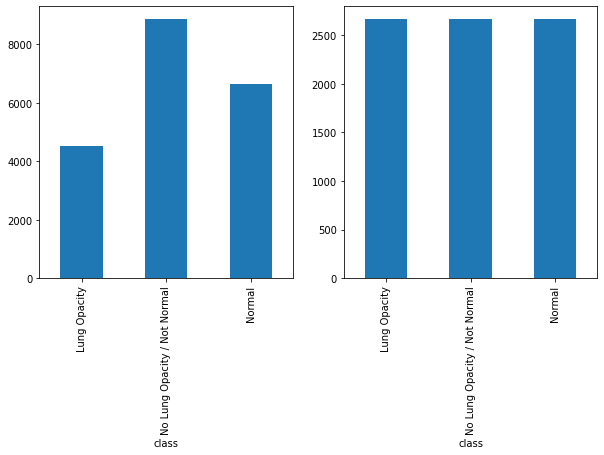

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
raw_train_df.groupby('class').size().plot.bar(ax=ax1)
train_df = raw_train_df.groupby('class').\
    apply(lambda x: x.sample(TRAIN_SAMPLES//3)).\
    reset_index(drop=True)
train_df.groupby('class').size().plot.bar(ax=ax2) 
print(train_df.shape[0], 'new training size')

In [ ]:
try:
    # keras 2.2
    import keras_preprocessing.image as KPImage
except:
    # keras 2.1
    import keras.preprocessing.image as KPImage
    
from PIL import Image
import pydicom
def read_dicom_image(in_path):
    img_arr = pydicom.read_file(in_path).pixel_array
    return img_arr/img_arr.max()
    
class medical_pil():
    @staticmethod
    def open(in_path):
        if '.dcm' in in_path:
            c_slice = read_dicom_image(in_path)
            int_slice =  (255*c_slice).clip(0, 255).astype(np.uint8) # 8bit images are more friendly
            return Image.fromarray(int_slice)
        else:
            return Image.open(in_path)
    fromarray = Image.fromarray
KPImage.pil_image = medical_pil

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET52':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='Xception':
    from keras.applications.xception import Xception as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169': 
    from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet121':
    from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

In [ ]:
img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.05, 
                              width_shift_range = 0.02, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05,
                               preprocessing_function=preprocess_input)
img_gen = ImageDataGenerator(**img_gen_args)

In [ ]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, seed = None, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways: seed: {}'.format(seed))
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                              seed = seed,
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values,0)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [ ]:
# train_gen = flow_from_dataframe(img_gen, train_df, 
#                              path_col = 'path',
#                             y_col = 'class_vec', 
#                             target_size = IMG_SIZE,
#                              color_mode = 'rgb',
#                             batch_size = BATCH_SIZE)

# valid_gen = flow_from_dataframe(img_gen, valid_df, 
#                              path_col = 'path',
#                             y_col = 'class_vec', 
#                             target_size = IMG_SIZE,
#                              color_mode = 'rgb',
#                             batch_size = 256) # we can use much larger batches for evaluation
# # used a fixed dataset for evaluating the algorithm
valid_X, valid_Y = next(flow_from_dataframe(img_gen, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'class_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 100)) # one big batch

## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 6671 images


IndexError: ignored

In [ ]:
valid_gen